<h1 align="center">MovieLens ALS Recomendation Model</h1> 
<h2 align="center">Amrit Sandhir</h2> 

### I: Use Case
### II: Exploratory Data Analysis
### III. Model Selection, Fit, Evaluation, and Recommendations
### IV: Conclusion

### I: Use Case

Recommendation systems are prolific and ubiqituous across the internet and websites.  Whether they are recommendations by Yelp for good Burmese restaurants in Los Angeles, emails sent by Redfin for house listings, or Netflix movie recemmendations, recommendation algorithms attempt to offer items that closely align with user interests. 

These algorithms can be generally broken down into two categories: content-based filtering models and collaborative filtering models.  Both try to offer relevant suggestions but do so in different ways.  

Content-based filtering models focus on each user's features and past behavior, and offer recomendations based on that user's features/behaviors.  For example, a website an indivdiual frequently visits has gathered information on previous items purchased, and then recommends other items resembling their purchase item history.  These recommendations are typcially based on categorizations or metadata to inform the model on revelant items.  Content-based filtering recommendations are effectively based on individual user behavior.

In contrast, collaborative filtering algorithms account for similarities *among users* when making recommendations and do not require metadata do so.  The user/item similarities are created mathematically by gathering patterns among users, whether explicitly provided, such as satisfaction ratings, or implicit, such as whether users 'did' or 'didn't do' something (e.g, viewed an item/movie).  The users/items groupings are inferred through a matrix factorization or decomposition process that derives latent (unobservable) feature associations between users and items.  This is very useful since building a reommendation model with pre-defined features is challenging and may not generate relevant predictions.  

The collaborative filtering model will be used in this analysis to generate user recommendations.  Specifically, Spark's Alternating Least Squares (ALS) model will be implemented on the smaller MovieLens dataset (https://grouplens.org/datasets/movielens/latest/).  The dataset contains users who've watched movies and given explicit ratings (i.e., if a user has watched a movie, they've provided a rating).  More details on the specific crieria can be found on https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html. While the dataset contains four csv files (ratings, movies, tags, and links), this analysis will utilize the ratings and movies csv files to build the model and evaluate predictions.  The data definitions and initial schema are provided below.   

The next step is to get familiar with the datasets thru Exploratory Data Analysis. 


<h1 align="center">Data Defnitions and Schema</h1> 

<h1 align="center">ratings.csv</h1> 

| Field      | Description       | Data Type     | Example | Min Value | Max Value
| :---       |     :----         |         :--- |  :----      | :---- | :----
| userId |  anonymized, unique user identifers | IntegerType() | 1 | 1 | 610 |
| movieId | unique movie identifer | IntegerType() | 1 | 1 | 193609 |
| rating | rating given by user | DoubleType() | 3.0 | 0.5 | 5.0 |
| timestamp | seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970 | StringType() | 1000129365 | 1000129365 | 999873731|



<h1 align="center">movies.csv</h1> 

| Field      | Description       | Data Type     | Example | Min Value | Max Value
| :---       |     :----         |         :--- |  :----      | :---- | :----
| movieId | unique movie identifer | IntegerType() | 4 | 1 | 193609 |
| title | movie title | StringType() | Waiting to Exhale (1995) | NA | NA |
| genre | genre(s) associated with movie | StringType() | Comedy, Drama, Romance | NA | NA |


### II: Exploratory Data Analysis

In [1]:
#import relevant packages
import pyspark
from platform import python_version
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession

#ML relevant packages
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

In [2]:
pyspark.__version__

'3.3.2'

In [3]:
python_version()

'3.9.16'

In [4]:
#build SparkSession instance
spark = pyspark.sql.SparkSession.builder \
                     .appName('recs_application') \
                     .config("spark.driver.maxResultSize", "8g") \
                     .config("spark.driver.memory", "12g") \
                     .config("spark.executor.memory", "12g") \
                     .config("spark.master", "local[1]") \
                     .config("spark.driver.extraJavaOptions", "-Ddev.ludovic.netlib.blas.nativeLib=libmkl_rt.so")\
                     .config("spark.sparkContext.setLogLevel", "ERROR")\
                     .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/04 11:00:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
#set schema for ratings dataframe 
schema=StructType([StructField('userId', IntegerType(), nullable=False),
         StructField('movieId', IntegerType(), nullable=False),
         StructField('rating', DoubleType(), nullable=False),
         StructField('timestamp', StringType(), nullable=False)])

#read in spark ratings dataframe
ratings_df=spark.read.csv('/Users/amritsandhir/Documents/ml-latest-small/ratings.csv', 
                          header=True, schema=schema)

In [6]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [7]:
#convert dates from unix timestamp column 'timestamp' to datetype
ratings_df=ratings_df.withColumn('date', from_unixtime(col('timestamp'), format='yyyy-MM-dd')).drop('timestamp')
ratings_df.show(5)

+------+-------+------+----------+
|userId|movieId|rating|      date|
+------+-------+------+----------+
|     1|      1|   4.0|2000-07-30|
|     1|      3|   4.0|2000-07-30|
|     1|      6|   4.0|2000-07-30|
|     1|     47|   5.0|2000-07-30|
|     1|     50|   5.0|2000-07-30|
+------+-------+------+----------+
only showing top 5 rows



In [8]:
ratings_df.select('date').agg({'date': 'min'}).show()
ratings_df.select('date').agg({'date': 'max'}).show()

+----------+
| min(date)|
+----------+
|1996-03-29|
+----------+

+----------+
| max(date)|
+----------+
|2018-09-24|
+----------+



In [9]:
rows=ratings_df.count()
cols=len(ratings_df.columns)

print('\n'+'\033[1m'+'The ratings dataset consists of {:d} rows and {:d} columns'.format(rows, cols))


The ratings dataset consists of 100836 rows and 4 columns


In [10]:
#calculating sparsity of data

nbr_users=ratings_df.select('userId').distinct().count()

nbr_movies=ratings_df.select('movieId').distinct().count()

sparsity=1-(rows/(nbr_users*nbr_users))

print('\n'+'\033[1m'+'The data is {:.1f}% sparse, which means of the {:d} potential data points only {:d}\n'\
      'are populated.'.format(sparsity*100, nbr_movies*nbr_users, rows))


The data is 72.9% sparse, which means of the 5931640 potential data points only 100836
are populated.


In [11]:
distnct_usrs=ratings_df.select('userId').distinct().count()
distnct_movies=ratings_df.select('movieId').distinct().count()

print('\n'+'\033[1m'+'The ratings dataset contains {:d} distinct viewers and {:d} distinct movie titles.'\
      .format(distnct_usrs, distnct_movies))


The ratings dataset contains 610 distinct viewers and 9724 distinct movie titles.


In [12]:
max_year=ratings_df.select(year(col('date')).alias('years')).agg({'years': 'max'}).collect()[0][0]

min_year=ratings_df.select(year(col('date')).alias('years')).agg({'years': 'min'}).collect()[0][0]

avg_nbr_movies_watched=ratings_df.groupBy('userId').count().select(round(avg('count'),2)\
                              .alias('avg_nbr_movies_watched_and_rated'))\
                              .collect()[0][0]

print('\n'+'\033[1m'+'Users have watched on average {} movies.\n'\
     'While this may seem high, we have to remember the dataset spans over {} years,\n'\
     'which translates to watching {:0.2f} movies per year on average.'\
      .format(avg_nbr_movies_watched, (max_year-min_year), avg_nbr_movies_watched/(max_year-min_year)))


Users have watched on average 165.3 movies.
While this may seem high, we have to remember the dataset spans over 22 years,
which translates to watching 7.51 movies per year on average.


In [13]:
ratings_df.agg(round(avg('rating'),2).alias('average rating given by users')).show()

median_rating=ratings_df.approxQuantile('rating',[0.5],0)[0]

print('\033[1m'+'Median rating given by users: {:.1f}'.format(median_rating))

+-----------------------------+
|average rating given by users|
+-----------------------------+
|                          3.5|
+-----------------------------+



Median rating given by users: 3.5


In [14]:
ratings_df.filter(ratings_df['userId'].isNull()).select('userId').show()
ratings_df.filter(ratings_df['movieId'].isNull()).select('movieId').show()
ratings_df.filter(ratings_df['rating'].isNull()).select('rating').show()
ratings_df.filter(ratings_df['date'].isNull()).select('date').show()

print('\033[1m'+'All columns are populated in the ratings dataset')

+------+
|userId|
+------+
+------+

+-------+
|movieId|
+-------+
+-------+

+------+
|rating|
+------+
+------+

+----+
|date|
+----+
+----+

All columns are populated in the ratings dataset


In [15]:
pandas_df=ratings_df.groupBy('rating').count().withColumn('freq', col('count')).drop(col('count')).toPandas()

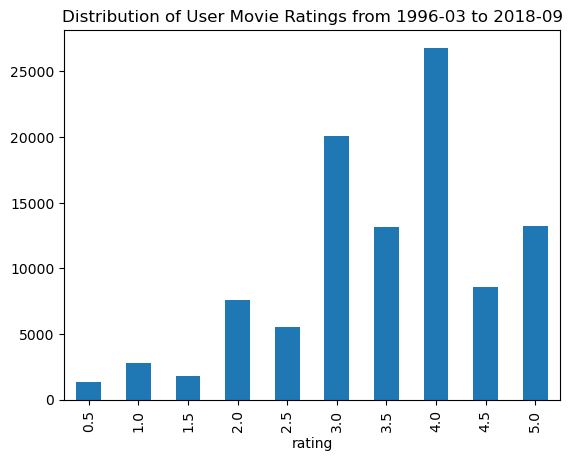

In [16]:
pandas_df.sort_values(by='rating').plot('rating', kind='bar', legend=False)
plt.title('Distribution of User Movie Ratings from 1996-03 to 2018-09', size=12)
plt.show()

In [17]:
#create spark movies dataframe with genres

movies_df=spark.read.csv('/Users/amritsandhir/Documents/ml-latest-small/movies.csv', 
                          header=True, inferSchema=True)

movies_df.printSchema()

movies_df.show(5, truncate=False)

nbr_movies=movies_df.select('title').distinct().count()
print('\n'+'\033[1m'+'\nThere are {:d} movies in the movies dataset.'.format(nbr_movies))

root
 |-- movieId: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- genres: string (nullable = true)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



There are 9737 movies in the movies dataset.


In [18]:
#creating genre_array for genres
udf_clm_split = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
movies_df=movies_df.withColumn('genre_array', udf_clm_split('genres')).drop('genres')
movies_df.show(5, truncate=False)

+-------+----------------------------------+-------------------------------------------------+
|movieId|title                             |genre_array                                      |
+-------+----------------------------------+-------------------------------------------------+
|1      |Toy Story (1995)                  |[Adventure, Animation, Children, Comedy, Fantasy]|
|2      |Jumanji (1995)                    |[Adventure, Children, Fantasy]                   |
|3      |Grumpier Old Men (1995)           |[Comedy, Romance]                                |
|4      |Waiting to Exhale (1995)          |[Comedy, Drama, Romance]                         |
|5      |Father of the Bride Part II (1995)|[Comedy]                                         |
+-------+----------------------------------+-------------------------------------------------+
only showing top 5 rows



In [19]:
movies_df.createOrReplaceTempView('movies_temp')

query='select genres from movies_temp lateral view explode(genre_array) exploded_table as genres'

distnct_genres_df=spark.sql(query).groupBy('genres')\
                .agg(count('genres').alias('nbr_movies_by_genre')).sort(desc('nbr_movies_by_genre'))

total=distnct_genres_df.groupBy().sum().collect()[0][0]

distnct_genres_df=distnct_genres_df.withColumn('percent', round((col('nbr_movies_by_genre')/total)*100,3))

print('\n'+'\033[1m'+'Drama, Comedy, and Thriller are the three highest individual genres\n')
distnct_genres_df.show()


Drama, Comedy, and Thriller are the three highest individual genres

+------------------+-------------------+-------+
|            genres|nbr_movies_by_genre|percent|
+------------------+-------------------+-------+
|             Drama|               4361| 19.747|
|            Comedy|               3756| 17.008|
|          Thriller|               1894|  8.576|
|            Action|               1828|  8.277|
|           Romance|               1596|  7.227|
|         Adventure|               1263|  5.719|
|             Crime|               1199|  5.429|
|            Sci-Fi|                980|  4.438|
|            Horror|                978|  4.429|
|           Fantasy|                779|  3.527|
|          Children|                664|  3.007|
|         Animation|                611|  2.767|
|           Mystery|                573|  2.595|
|       Documentary|                440|  1.992|
|               War|                382|   1.73|
|           Musical|                334|  1.512|

In [20]:
#creating a random set of 5 unique users
dstnct_users=ratings_df.select('userId').distinct()

smpl_usrs_df=dstnct_users.sample(withReplacement=False, fraction=0.5, seed=42).limit(5)

smpl_usrs_lst=list(smpl_usrs_df.toPandas()['userId'])

smpl_usrs_lst

[496, 31, 137, 451, 53]

In [21]:
movie_rating_smpl_usrs_df=ratings_df.join(broadcast(movies_df), on='movieId', how='left')\
                                .join(broadcast(smpl_usrs_df), on='userId', how='inner')

usr_496=movie_rating_smpl_usrs_df.filter(col('userId')==496).orderBy(['rating', 'movieId'], ascending=False).limit(5)
usr_31=movie_rating_smpl_usrs_df.filter(col('userId')==31).orderBy(['rating', 'movieId'], ascending=False).limit(5)
usr_137=movie_rating_smpl_usrs_df.filter(col('userId')==137).orderBy(['rating', 'movieId'], ascending=False).limit(5)
usr_451=movie_rating_smpl_usrs_df.filter(col('userId')==451).orderBy(['rating', 'movieId'], ascending=False).limit(5)
usr_53=movie_rating_smpl_usrs_df.filter(col('userId')==53).orderBy(['rating', 'movieId'], ascending=False).limit(5)

print('\n'+'\033[1m'+'Five top rated movies of five random users\n')
usr_496.union(usr_31).union(usr_137).union(usr_451).union(usr_53).show(5*5)

usr_496_l=movie_rating_smpl_usrs_df.filter(col('userId')==496).orderBy(['rating', 'movieId'], ascending=True).limit(5)
usr_31_l=movie_rating_smpl_usrs_df.filter(col('userId')==31).orderBy(['rating', 'movieId'], ascending=True).limit(5)
usr_137_l=movie_rating_smpl_usrs_df.filter(col('userId')==137).orderBy(['rating', 'movieId'], ascending=True).limit(5)
usr_451_l=movie_rating_smpl_usrs_df.filter(col('userId')==451).orderBy(['rating', 'movieId'], ascending=True).limit(5)
usr_53_l=movie_rating_smpl_usrs_df.filter(col('userId')==53).orderBy(['rating', 'movieId'], ascending=True).limit(5)


print('\n'+'\033[1m'+'Five lowest rated movies of five random users\n')
usr_496_l.union(usr_31_l).union(usr_137_l).union(usr_451_l).union(usr_53_l).show(5*5)

print('\n'+'\033[1m'+'Interestingly userId 53 is quite enthusiastic about movies watched.\n'\
      'Even their lowest provided ratings are 5 stars.')


Five top rated movies of five random users



+------+-------+------+----------+--------------------+--------------------+
|userId|movieId|rating|      date|               title|         genre_array|
+------+-------+------+----------+--------------------+--------------------+
|   496|    904|   5.0|2014-11-04|  Rear Window (1954)| [Mystery, Thriller]|
|   496|    858|   5.0|2014-11-04|Godfather, The (1...|      [Crime, Drama]|
|   496| 106920|   4.5|2014-11-04|          Her (2013)|[Drama, Romance, ...|
|   496|  58559|   4.5|2014-11-09|Dark Knight, The ...|[Action, Crime, D...|
|   496|    912|   4.5|2014-11-04|   Casablanca (1942)|    [Drama, Romance]|
|    31|   5060|   5.0|1996-12-13|M*A*S*H (a.k.a. M...|[Comedy, Drama, War]|
|    31|   1391|   5.0|1996-12-13|Mars Attacks! (1996)|[Action, Comedy, ...|
|    31|   1363|   5.0|1996-12-13|Preacher's Wife, ...|             [Drama]|
|    31|   1361|   5.0|1996-12-13|Paradise Lost: Th...|       [Documentary]|
|    31|   1282|   5.0|1996-12-13|     Fantasia (1940)|[Animation, Child...|

### III. Model Selection, Fit, Evaluation, and Recommendations

Now that we're familar with the underlying data, the ratings dataframe will be randomly split into training and test sets.  Using the ALS model as the base model, 5-fold cross validation will be done on the training set with a grid search on the ALS rank parameter (i.e., number of latent features the model should hold) and the regParam (degree to which the model is regularized, higher regParam values penalize model overfitting).  

Since we are provided explicit preferences (user ratings), the evaluation metric will be the root mean squared error (rsme).  It  measures of how far, on average, the model's predicted ratings are from true ratings.  The cross validated model with the lowest rsme (i.e., best model) will then be used for predictions on the test set.  

Lastly, we will use this model to recommend movies not seen by 5 randomly selected users. 

In [22]:
train, test = ratings_df.randomSplit([0.8,0.2], seed=42)

als=ALS(userCol="userId", itemCol="movieId", ratingCol="rating",
        nonnegative=True, coldStartStrategy="drop", 
        implicitPrefs=False)


ranks=[10, 15, 20]
max_iter=[20]
reg_param=[0.1, 0.5, 0.9]

param_grid=ParamGridBuilder().addGrid(als.rank, ranks).addGrid(als.maxIter, max_iter)\
                             .addGrid(als.regParam, reg_param)\
                             .build()

#evaluate performance using root mean squared error (rsme) metric
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol='prediction')

cv=CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

als_model=cv.fit(train)

23/04/04 11:00:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/04/04 11:00:36 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [23]:
print('\n\033[1m'+'RSMEs produced thru cross validation:\n')
np.round(als_model.avgMetrics,4)


RSMEs produced thru cross validation:



array([0.8997, 1.0097, 1.2519, 0.8991, 1.0097, 1.2519, 0.9001, 1.0097,
       1.2519])

In [24]:
rslts=[*zip(als_model.avgMetrics, param_grid)]

In [25]:
rslts_arry=np.array(rslts)

In [26]:
rslts_arry[:2]

array([[0.8996885430132571,
        {Param(parent='ALS_eed884b01e37', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_eed884b01e37', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_eed884b01e37', name='regParam', doc='regularization parameter (>= 0).'): 0.1}],
       [1.0096708851311447,
        {Param(parent='ALS_eed884b01e37', name='rank', doc='rank of the factorization'): 10, Param(parent='ALS_eed884b01e37', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='ALS_eed884b01e37', name='regParam', doc='regularization parameter (>= 0).'): 0.5}]],
      dtype=object)

In [27]:
#get the index of lowest rsme generated from cross validation results
idx=np.argmin(rslts_arry[:,0])

best_rsme=rslts[idx]

best_hyper_params=[*zip(('rank', 'maxIter', 'regParam'),list(rslts_arry[3][1].values()))]

In [28]:
print('\n\033[1m'+'With the cross validation results, the best model had an rmse of {:0.4f}\n'\
      'with hyperparameters {}: {}, {}: {}, and {}: {}.'
      .format(best_rsme[0], best_hyper_params[0][0], best_hyper_params[0][1],
             best_hyper_params[1][0], best_hyper_params[1][1], 
             best_hyper_params[2][0], best_hyper_params[2][1]))


With the cross validation results, the best model had an rmse of 0.8991
with hyperparameters rank: 15, maxIter: 20, and regParam: 0.1.


In [29]:
#best model (i.e., lowest rsme) produced thru cross validation
best_model=als_model.bestModel

#generate predictions on the test set with the best model 
predictions=best_model.transform(test)

In [30]:
predictions.orderBy('prediction', ascending=False).show()

predictions.orderBy('prediction', ascending=True).show()

print('\n\033[1m'+'The predictions output produces ratings out of range 0.5 to 5, which doesn\'t make sense\n'\
      'since 0.5 is lowest possible rating and 5 is the higest rating possible.\n'\
      'Let\'s limit any rating below 0.5 to 0.5 and above 5 to 5.')

+------+-------+------+----------+----------+
|userId|movieId|rating|      date|prediction|
+------+-------+------+----------+----------+
|    53|   3100|   5.0|2009-03-22| 5.4888086|
|   171|   1104|   5.0|1997-06-21| 5.3132668|
|    25| 177593|   5.0|2018-08-28| 5.2914305|
|    99|    318|   5.0|1996-04-18| 5.2090483|
|    93|    318|   4.0|1999-11-18| 5.1751447|
|   276|      1|   4.0|1997-03-14| 5.1596756|
|   371|   1206|   5.0|2014-08-10| 5.1410346|
|   375|   4226|   5.0|2008-10-29| 5.1326966|
|   452|   4011|   5.0|2002-04-23|  5.126504|
|   597|    922|   5.0|1999-10-19| 5.1191196|
|   584|    356|   5.0|1996-06-16| 5.1112638|
|    20|    899|   4.0|2003-05-28|  5.092892|
|   371|   1274|   5.0|2014-08-10|  5.088125|
|    30|    318|   5.0|2017-07-18|  5.083262|
|   122|   1089|   5.0|2016-04-24|  5.064089|
|   515|     50|   4.5|2017-12-19| 5.0613194|
|   572|    527|   5.0|1999-12-22| 5.0553827|
|   275|   3468|   5.0|2003-03-30|  5.050259|
|   171|   1201|   5.0|1997-06-21|

+------+-------+------+----------+----------+
|userId|movieId|rating|      date|prediction|
+------+-------+------+----------+----------+
|   448|  79879|   3.0|2012-08-26| 0.2805143|
|   599|   6348|   2.5|2017-06-26|0.31717357|
|   571|   1325|   2.0|2000-08-21| 0.3228615|
|   610|  79879|   3.0|2017-05-03| 0.3375515|
|   119| 108689|   4.0|2016-02-14|0.35852453|
|    68|   8677|   2.0|2006-09-17|0.36050963|
|   217|   3431|   2.0|2000-04-16|   0.36128|
|   448|   6348|   2.0|2003-06-01| 0.3713381|
|   382| 152079|   3.5|2018-01-05|0.39066577|
|   313|   2363|   3.0|2002-08-27|0.40284455|
|   265|   2364|   2.0|2000-08-03|0.40816408|
|   219|  55292|   1.0|2008-01-21|0.42049104|
|   307|   5538|   2.0|2007-09-12|0.44428742|
|   307|   5539|   2.0|2007-09-12|0.44428742|
|    62| 128512|   3.5|2018-04-06| 0.4455455|
|   571|   1326|   2.0|2000-08-21|0.45792106|
|   377|   8138|   4.0|2012-06-21| 0.4813703|
|   599|   6320|   2.0|2017-06-26| 0.5087939|
|   274|   4241|   3.0|2007-02-23|

In [31]:
predictions=predictions.withColumn('prediction',
                                   when(predictions.prediction<0.5, 0.5)
                                   .when(predictions.prediction>5,5)
                                   .otherwise(predictions.prediction))

predictions.orderBy('prediction', ascending=False).show()

predictions.orderBy('prediction', ascending=True).show()

+------+-------+------+----------+----------+
|userId|movieId|rating|      date|prediction|
+------+-------+------+----------+----------+
|   171|   1104|   5.0|1997-06-21|       5.0|
|   375|   4226|   5.0|2008-10-29|       5.0|
|   171|   1201|   5.0|1997-06-21|       5.0|
|    53|   3100|   5.0|2009-03-22|       5.0|
|   597|    922|   5.0|1999-10-19|       5.0|
|   122|    593|   5.0|2016-04-24|       5.0|
|   122|   1089|   5.0|2016-04-24|       5.0|
|   572|    527|   5.0|1999-12-22|       5.0|
|    93|    593|   5.0|1999-11-18|       5.0|
|   224|    527|   5.0|2000-10-17|       5.0|
|   494|   1204|   3.0|2001-09-13|       5.0|
|   122|   1213|   5.0|2016-04-24|       5.0|
|    93|    318|   4.0|1999-11-18|       5.0|
|    20|    899|   4.0|2003-05-28|       5.0|
|   452|   4011|   5.0|2002-04-23|       5.0|
|    51|    522|   3.5|2009-01-02|       5.0|
|    25| 177593|   5.0|2018-08-28|       5.0|
|   371|   1206|   5.0|2014-08-10|       5.0|
|   371|   1274|   5.0|2014-08-10|

+------+-------+------+----------+------------------+
|userId|movieId|rating|      date|        prediction|
+------+-------+------+----------+------------------+
|   599|   6348|   2.5|2017-06-26|               0.5|
|   217|   3431|   2.0|2000-04-16|               0.5|
|   265|   2364|   2.0|2000-08-03|               0.5|
|   307|   5538|   2.0|2007-09-12|               0.5|
|   307|   5539|   2.0|2007-09-12|               0.5|
|    68|   8677|   2.0|2006-09-17|               0.5|
|    62| 128512|   3.5|2018-04-06|               0.5|
|   219|  55292|   1.0|2008-01-21|               0.5|
|   382| 152079|   3.5|2018-01-05|               0.5|
|   119| 108689|   4.0|2016-02-14|               0.5|
|   571|   1325|   2.0|2000-08-21|               0.5|
|   571|   1326|   2.0|2000-08-21|               0.5|
|   313|   2363|   3.0|2002-08-27|               0.5|
|   448|   6348|   2.0|2003-06-01|               0.5|
|   377|   8138|   4.0|2012-06-21|               0.5|
|   448|  79879|   3.0|2012-

In [32]:
#calculate RSME on predictions of test set
rmse=evaluator.evaluate(predictions)

print('\n\033[1m'+'RMSE: {:0.2f} on test set.'.format(rmse))


RMSE: 0.87 on test set.


In [33]:
smpl_usrs_lst

[496, 31, 137, 451, 53]

In [34]:
predictions.filter(predictions['userID'].isin(496, 31, 137, 451, 53))\
           .select('userId', 'movieId', 'rating', 'prediction').show(10)

+------+-------+------+------------------+
|userId|movieId|rating|        prediction|
+------+-------+------+------------------+
|   137|    858|   5.0| 4.438312530517578|
|   451|    481|   3.0|3.2104594707489014|
|   137|   3198|   3.5|3.6647322177886963|
|   496| 106920|   4.5|3.9127352237701416|
|   137|   1093|   4.0| 3.147963523864746|
|   137|    924|   4.0| 4.158868312835693|
|   137|   1207|   3.0|  4.04432487487793|
|   137|    912|   5.0| 4.404143810272217|
|   496|    912|   4.5|3.8968987464904785|
|   137|   1304|   4.5|  4.10524845123291|
+------+-------+------+------------------+
only showing top 10 rows



In [35]:
#return top 5 predicted ratings on smpl_usrs
user_subset = predictions.select('userID').where(col('userID').isin(496, 31, 137, 451, 53)).distinct()

top_predictions_subset_users=best_model.recommendForUserSubset(user_subset, 5)

top_predictions_subset_users.show(truncate=False)

+------+---------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                    |
+------+---------------------------------------------------------------------------------------------------+
|496   |[{306, 4.6274776}, {89759, 4.5466237}, {85, 4.5039053}, {6591, 4.4702306}, {89904, 4.387729}]      |
|31    |[{67618, 5.3032565}, {7121, 5.2470803}, {25771, 5.1859617}, {89745, 5.140826}, {183897, 5.0807595}]|
|451   |[{96004, 5.3021526}, {3379, 5.3021526}, {171495, 5.256518}, {7767, 5.1576734}, {2360, 5.1573043}]  |
|137   |[{96004, 4.690007}, {3379, 4.690007}, {4406, 4.6743455}, {6650, 4.580536}, {3030, 4.5738406}]      |
|53    |[{96004, 6.4878244}, {3379, 6.4878244}, {171495, 6.478397}, {32892, 6.364195}, {1274, 6.3271685}]  |
+------+---------------------------------------------------------------------------------------------------+



In [36]:
top_predictions_subset_users.createOrReplaceTempView("top_predictions_usr_subset_tmp")

subset_usr_recs=spark.sql("""SELECT userId,
                                 movieIds_and_ratings.movieId AS movieId,
                                 movieIds_and_ratings.rating AS prediction
                       FROM top_predictions_usr_subset_tmp
                       LATERAL VIEW explode(recommendations) exploded_table
                       AS movieIds_and_ratings""")

In [37]:
subset_usr_movie_recs=subset_usr_recs.join(broadcast(movies_df), on='movieId', how='left')\
                                     .join(ratings_df, on=['userId', 'movieId'], how='left')


subset_usr_movie_recs=subset_usr_movie_recs.withColumn('prediction',
                                                       when(subset_usr_movie_recs.prediction<0.5, 0.5)
                                                      .when(subset_usr_movie_recs.prediction>5,5)
                                                      .otherwise(subset_usr_movie_recs.prediction))

subset_usr_movie_recs=subset_usr_movie_recs.withColumn('prediction', round('prediction',1))

subset_usr_movie_recs=subset_usr_movie_recs.select('userId', 'movieId', 'title', 
                                                   'rating', 'prediction', 'genre_array')


#recommendations for unseen movies on sample users
subset_usr_movie_recs.filter(subset_usr_movie_recs['rating'].isNull())\
                      .orderBy('userId').show(5*5)

+------+-------+--------------------+------+----------+--------------------+
|userId|movieId|               title|rating|prediction|         genre_array|
+------+-------+--------------------+------+----------+--------------------+
|    31|  67618|Strictly Sexual (...|  null|       5.0|[Comedy, Drama, R...|
|    31|  89745|Avengers, The (2012)|  null|       5.0|[Action, Adventur...|
|    31|   7121|   Adam's Rib (1949)|  null|       5.0|   [Comedy, Romance]|
|    31| 183897| Isle of Dogs (2018)|  null|       5.0| [Animation, Comedy]|
|    31|  25771|Andalusian Dog, A...|  null|       5.0|           [Fantasy]|
|    53|  96004|Dragon Ball Z: Th...|  null|       5.0|[Action, Adventur...|
|    53|   3379| On the Beach (1959)|  null|       5.0|             [Drama]|
|    53|  32892|Ivan's Childhood ...|  null|       5.0|        [Drama, War]|
|    53| 171495|              Cosmos|  null|       5.0|[(no genres listed)]|
|    53|   1274|        Akira (1988)|  null|       5.0|[Action, Adventur...|

In [38]:
spark.stop()

### IV: Conclusion

ALS models can be quite powerful in making recommendations without need for defining explicit features a priori.  The rank hyperparameter controls the number of latent features, and the complexity of the model.  We had allowed the cross validation to search rank values of 10, 15, and 20, and it returned rank 15 with regularization 0.1.  This underscores that more complex models are not necessarily better models.  We could have also allowed for varying the maxIter parameter, which controls the number of iterations the matrix factorization goes thru to approximate the original user-item matrix.  This however becomes computationally expensive especially when the calculations are done on a local machine, as opposed to a cluster.

The final output above recommended movies not viewed for a select random sample of users.  Ultimately a model will get evaluated on whether viewers/users are responsive to recommendations and, after having a watched a movie, user ratings are close to predicted ratings.  In a production environment, we also have to consider the implementation of recommendation systems.  Whether recommendations are computed off-line, and then served, or done in real-time requires an understanding of daily user traffic (load) and coordination with engineers on the appropriate platform and architecture for the use case.   